In [2]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Multiple linear regression model
### Let's mimic the process of building our trading model of SPY, base on the historical data of different stock markets
1. Response=open mkt priceo SPY tomorrow-mkt price today
2. 3 groups of predictors 9total(see data munging):
1day lag prices usmkt,1day lag_starting at noon est if have intraday data_for european mkts, 1 day prices asian mkts

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# import all stock market data into DataFrame
## We can see that the regression model (MEDV~LSTAT) violates all four assumptions. Therefore, we cannot make statistical inference using this model.
aord = pd.DataFrame.from_csv('../data/indice/ALLOrdinary.csv')
nikkei = pd.DataFrame.from_csv('../data/indice/Nikkei225.csv')
hsi = pd.DataFrame.from_csv('../data/indice/HSI.csv')
daxi = pd.DataFrame.from_csv('../data/indice/DAXI.csv')
cac40 = pd.DataFrame.from_csv('../data/indice/CAC40.csv')
sp500 = pd.DataFrame.from_csv('../data/indice/SP500.csv')
dji = pd.DataFrame.from_csv('../data/indice/DJI.csv')
nasdaq = pd.DataFrame.from_csv('../data/indice/nasdaq_composite.csv')
spy = pd.DataFrame.from_csv('../data/indice/SPY.csv')

In [9]:
#be sure all ata has same coulmns,etc  
spy.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,146.529999,146.990005,143.880005,144.929993,116.593864,204935600
2008-01-03,144.910004,145.490005,144.070007,144.860001,116.537567,125133300
2008-01-04,143.339996,143.440002,140.910004,141.309998,113.681671,232330900
2008-01-07,141.809998,142.229996,140.100006,141.190002,113.585121,234991000
2008-01-08,142.080002,142.899994,138.440002,138.910004,111.750923,326365700


In [6]:
cac40.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,8045.970215,8100.640137,7925.109863,7949.109863,7949.109863,110721200.0
2008-01-03,7941.520020,7969.899902,7858.390137,7908.410156,7908.410156,128154400.0
2008-01-04,7913.529785,7914.700195,7780.270020,7808.689941,7808.689941,180875100.0
2008-01-07,7810.819824,7858.640137,7781.680176,7817.169922,7817.169922,188030700.0
2008-01-08,7844.500000,7923.439941,7831.509766,7849.990234,7849.990234,186940800.0


## Step 1: Data Munging

In [6]:
# Due to the timezone issues, we extract and calculate appropriate stock market data for analysis
# first create empty df w index=index of spy
# this Indicepanel is the DataFrame of our trading model
indicepanel=pd.DataFrame(index=spy.index)
#then calculate all response and predictors:
#response
indicepanel['spy']=spy['Open'].shift(-1)-spy['Open']
#lag us mkts
indicepanel['spy_lag1']=indicepanel['spy'].shift(1)
indicepanel['sp500']=sp500['Open']-sp500['Open'].shift(1)
indicepanel['nasdaq']=nasdaq['Open']-nasdaq['Open'].shift(1)
indicepanel['dji']=dji['Open']-dji['Open'].shift(1)
#lag eu mkts
indicepanel['cac40']=cac40['Open']-cac40['Open'].shift(1)
indicepanel['daxi']=daxi['Open']-daxi['Open'].shift(1)
#asian mkts
indicepanel['aord']=aord['Close']-aord['Open']
indicepanel['hsi']=hsi['Close']-hsi['Open']
indicepanel['nikkei']=nikkei['Close']-nikkei['Open']
#spy open price to use later
indicepanel['Price']=spy['Open']

In [7]:
indicepanel.tail(5)
#our model

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
2018-08-15,1.019989,-0.540008,0.070068,-37.859863,19.67969,-22.680176,-44.360352,29.500000,-401.130859,-163.898438,282.380005
2018-08-16,0.429993,1.019989,3.489990,16.930175,59.60156,-88.580078,-198.139648,-3.100097,228.951172,211.218750,283.399994
2018-08-17,1.740020,0.429993,6.880127,-40.310058,255.83008,30.320312,39.929687,13.600097,-175.160157,-42.808594,283.829987
2018-08-20,0.679993,1.740020,15.609864,47.729980,176.89844,5.879883,20.950196,9.300293,324.240234,-68.070313,285.570007
2018-08-21,NaN,0.679993,7.580078,5.719727,59.29101,9.649903,57.549804,-52.100098,82.250000,109.191406,286.250000


In [8]:
# Lets check whether do we have NaN values in indicepanel
indicepanel.isnull().sum()

spy           1
spy_lag1      1
sp500         1
nasdaq        1
dji           1
cac40        30
daxi         53
aord        319
hsi         121
nikkei      145
Price         0
dtype: int64

In [9]:
#diffmkts have diff holidays,weekends,etc     
#We can use method 'fillna()' from dataframe to forward filling the Nan values
# Then we can drop the reminding Nan values
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

In [10]:
# Lets check whether do we have Nan values in indicepanel now
indicepanel.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [11]:
# save this indicepanel for part 4.5
path_save = '../data/indicepanel.csv'
indicepanel.to_csv(path_save)

In [12]:
#2677 days of data, 11=9parameters+1response+1open of spy
print(indicepanel.shape)

(2677, 11)


## Step 2: Data Spliting

In [ ]:
#split the data into (1)train set and (2)test set
#use = size data since stocks are very noisy
#use 1000 days before to current for test and 1000 days before that to trrain
Train = indicepanel.iloc[-2000:-1000, :]
Test = indicepanel.iloc[-1000:, :]
print(Train.shape, Test.shape)

## Step 3: Explore the train data set

In [ ]:
# Generate scatter matrix among all stock markets (and the price of SPY) 
#to observe the associations..lots of noise
from pandas.tools.plotting import scatter_matrix
sm = scatter_matrix(Train, figsize=(10, 10))

## Step 4: Check the correlation of each index between spy

In [19]:
# Find the indice with largest correlation
corr_array = Train.iloc[:, :-1].corr()['spy']
print(corr_array)
#europe and asian mkts highly correlated vs us stocksw spy

spy         1.000000
spy_lag1   -0.011623
sp500      -0.018632
nasdaq      0.012333
dji        -0.037097
cac40      -0.055304
daxi       -0.069735
aord        0.179638
hsi         0.031400
nikkei     -0.035048
Name: spy, dtype: float64


In [22]:
#Calc Least mean squared fromStats
#look at p values of f test to test significance of model
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()
#p value of ftest= .0000000000697<.05 =overall significance of model at 5%error raTe
#Ho  is rejected, aka all parameters not =0 , so atleast1 of the predictors in our model is significant 
#now look at individual predictors p tests...
#Aaord is =0 thus null is accepted, aka this predictor has multicollinearity w other variable 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.962
Date:                Thu, 30 Jul 2020   Prob (F-statistic):           1.97e-11
Time:                        00:31:34   Log-Likelihood:                -1617.7
No. Observations:                1000   AIC:                             3255.
Df Residuals:                     990   BIC:                             3305.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0836      0.039      2.138      0.033       0.007       0.160
spy_lag1      -0.1567      0.091     -1.730      0.084      -0.335       0.021
sp500          0.0221      0.014      1.621      0.105      -0.005       0.049
nasdaq         0.0040      0.004      1.066      0.287      -0.003       0.011
dji           -0.0018      0.001     -1.248      0.212      -0.005       0.001
cac40         -0.0003      0.002     -0.153      0.879      -0.004       0.004
aord           0.0093      0.001      7.492      0.000       0.007       0.012
daxi          -0.0025      0.001     -2.387      0.017      -0.005      -0.000
nikkei        -0.0004      0.000     -1.264      0.207      -0.001       0.000
hsi            0.0003      0.000      1.222      0.222      -0.000       0.001
==============================================================================
Omnibus:                       91.018   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.687
Skew:                          -0.450   Prob(JB):                     7.45e-59
Kurtosis:                       5.369   Cond. No.                         405.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step 5: Make prediction

In [23]:
#predict on Spy for our model train and test
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

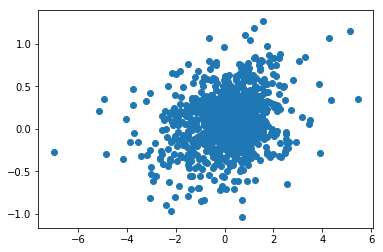

In [61]:
#looking 4a linear relationship__ours=daily chage thus itsnnot too bad
plt.scatter(Train['spy'], Train['PredictedY'])

## Step 6: Model evaluation - Statistical standard

We can measure the performance of our model using some statistical metrics - **RMSE=measures prediction error (sqr rt of sum of square errors avged by degree of freedom) **, **Adjusted $R^2$=%of variation  that can b explained by the model **

In [62]:
# calculates RMSE - Root Mean Squared Error &Adjusted R^2
#note k isnumber of predictors y is coulun name of our response variable 
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE
#def defines function, return gives data of function

In [63]:
# comparing rmse and r2 tests from train &test
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [64]:
# Get the assement table for our model
#compares train/test, want both to be similar
assessTable(Test, Train, lm, 9, 'spy')

,Train,Test
R2,0.059020,0.067248
RMSE,1.226068,1.701291


#OVERFITTING: WHEN R2 AND RMSE LOOK much better in test than in train..for stock mkt r2 of 1.5% is not that bad